# Calculation of 2d projection

Project 3D (world) to 2D (image space) using camera parameters.json file from https://github.com/karfly/human36m-camera-parameters/blob/master/camera-parameters.json

json file consists of extrinsic and intrinsic parameters.

#### Load json file:

Load the json file. 

You can get json file from https://github.com/karfly/human36m-camera-parameters/blob/master/camera-parameters.json

In [1]:
import numpy as np
import json

# === Load JSON camera parameters ===
with open('camera-parameters.json') as f:
    camera_parameter = json.load(f)

In [2]:
# === Load 3D world coordinates ===
data_3d = np.load('data_3d_h36m.npz', allow_pickle=True)['positions_3d'].item()
subject = 'S1'
action = 'Smoking'
frame_idx = 100
view_2d = 1

# Camera IDs per view index
camera_id = {
    0: '54138969',
    1: '55011271',
    2: '58860488',
    3: '60457274'
}
cam_id = camera_id[view_2d]

In [3]:
rotation_matrix = camera_parameter['extrinsics'][subject][str(camera_id[view_2d])]['R']
rotation_matrix

[[0.9281683400814921, 0.3721538354721445, 0.002248380248018696],
 [0.08166409428175585, -0.1977722953267526, -0.976840363061605],
 [-0.3630902204349604, 0.9068559102440475, -0.21395758897485287]]

In [4]:
translation_vector = camera_parameter['extrinsics'][subject][str(camera_id[view_2d])]['t']
translation_vector

[[251.42516271750836], [420.9422103702068], [5588.195881837821]]

In [5]:
cam_matrix = camera_parameter['intrinsics'][str(camera_id[view_2d])]['calibration_matrix']
cam_matrix

[[1149.67569986785, 0.0, 508.848621645943],
 [0.0, 1147.59161666764, 508.064917088557],
 [0.0, 0.0, 1.0]]

Load 3D world coordinates from data_3d_h36m.npz file.

Also choose the subject action and frame.


In [6]:
# Convert from list to NumPy array if necessary
data_all_frames = np.array(data_3d[subject][action])  # shape: (num_frames, 32, 3)

# Get single frame
data_3d = data_all_frames[frame_idx]  # shape: (32, 3)
print(data_3d.shape)  # Make sure it's (32, 3)


(32, 3)


Convert 32 keypoint style to 17.

In [7]:
# === Step 1: Extract and convert 3D world pose to 17 joints ===
h36m_to_17 = [0, 1, 2, 3, 6, 7, 8, 12, 13, 14, 15, 17, 18, 19, 25, 26, 27]
data_3d_world = data_3d[h36m_to_17]  # shape: (17, 3)
print(data_3d_world)
data_3d_world.shape

[[-0.0783266  -0.16242     0.940099  ]
 [-0.21088575 -0.156166    0.948117  ]
 [-0.17553662 -0.126362    0.5076425 ]
 [-0.15521166 -0.06389793  0.05821105]
 [ 0.05423278 -0.168674    0.932081  ]
 [ 0.05533141 -0.16319399  0.48922184]
 [ 0.0808828  -0.10095847  0.04002532]
 [-0.08963297 -0.12000001  1.1694095 ]
 [-0.0962164  -0.12311961  1.4263839 ]
 [-0.15867679 -0.19890411  1.4972999 ]
 [-0.15767922 -0.16035117  1.6056429 ]
 [ 0.04048261 -0.13393563  1.3630773 ]
 [ 0.13228881 -0.11496272  1.1004231 ]
 [ 0.19209294 -0.2017861   0.87182975]
 [-0.22655031 -0.08904244  1.3581028 ]
 [-0.31319866 -0.06435531  1.0941637 ]
 [-0.31727594 -0.3146815   1.0679433 ]]


(17, 3)

#### Get extrinsic parameters:

R and t (Rotation and translation) in json file looks like as shown below:

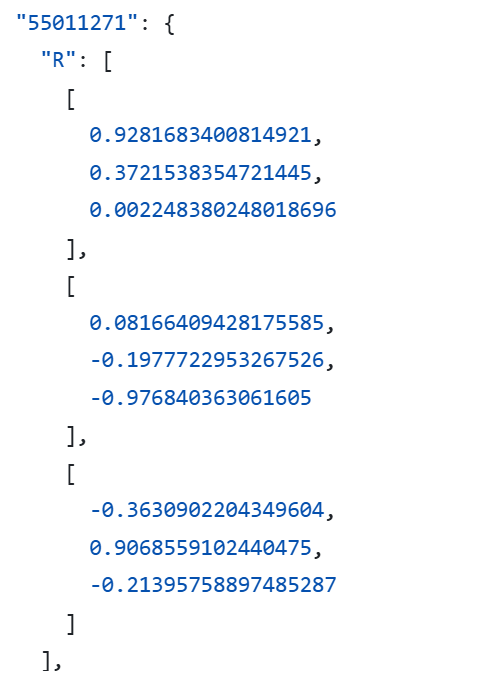

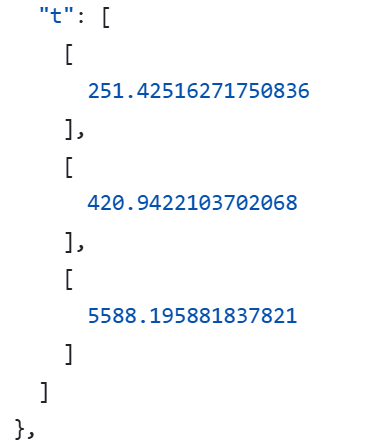

In [8]:
# === Step 2: Get Extrinsics (R, t) ===
R = np.array(camera_parameter['extrinsics'][subject][cam_id]['R'])         # (3, 3)
t = np.array(camera_parameter['extrinsics'][subject][cam_id]['t']).reshape(3,)  # (3,)
t = t / 1000.0  # Convert mm to meters to match 3D
print(R)
print()
print(t)

[[ 0.92816834  0.37215384  0.00224838]
 [ 0.08166409 -0.1977723  -0.97684036]
 [-0.36309022  0.90685591 -0.21395759]]

[0.25142516 0.42094221 5.58819588]


#### Transform world → camera coordinates

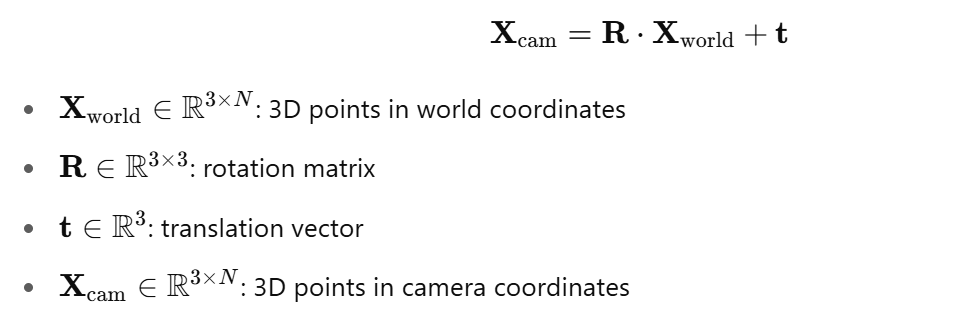

In [9]:
# === Step 3: Transform world → camera coordinates ===
X_world = data_3d_world.T  # (3, 17)
X_cam = R @ X_world + t[:, np.newaxis]  # (3, 17)

#### Normalize coordinates (x = X/Z, y = Y/Z)

In [10]:
# === Step 4: Normalize coordinates (x = X/Z, y = Y/Z) ===
x = X_cam[0, :] / X_cam[2, :]
y = X_cam[1, :] / X_cam[2, :]
xy = np.vstack([x, y])  # (2, 17)

#### Apply intrinsics:

In [14]:
# === Step 3: Apply intrinsics ===
fx = cam_matrix[0][0]
fy = cam_matrix[1][1]
cx = cam_matrix[0][2]
cy = cam_matrix[1][2]

u = fx * xy[0] + cx
v = fy * xy[1] + cy

# === Final 2D projection ===
proj_2d = np.stack([u, v], axis=1)  # shape (17, 2)
proj_2d


array([[535.12197093, 405.32179126],
       [508.78414795, 402.03640486],
       [517.8730272 , 494.47499944],
       [526.11466589, 583.01279594],
       [561.98584697, 408.67279431],
       [561.43922515, 503.71336937],
       [569.71915786, 593.92671575],
       [536.42343699, 354.30909129],
       [535.23882899, 297.35842018],
       [516.33201215, 281.60534756],
       [519.77509317, 256.87446208],
       [562.81237297, 312.19496368],
       [582.6648705 , 371.14832819],
       [588.46847402, 424.46232883],
       [511.24910139, 311.72989185],
       [495.93398574, 367.8937873 ],
       [473.89684451, 378.49192958]])

#### Checking with groundtruth 2D:

In [12]:
data_2d_file = 'data_2d_h36m_gt.npz'

# === Load 2D keypoints ===
data_2d_npz = np.load(data_2d_file, allow_pickle=True)
dataset_2d = data_2d_npz['positions_2d'].item()
gt_2d = dataset_2d[subject][action][view_2d][frame_idx]  # (17, 2) for this frame
print(gt_2d)

[[535.0685  405.442  ]
 [508.76834 402.15662]
 [517.8725  494.47464]
 [526.0878  582.91833]
 [561.87823 408.81018]
 [561.41046 503.70895]
 [569.5875  593.7366 ]
 [536.3011  354.74075]
 [535.01935 298.49408]
 [516.20953 282.99423]
 [519.5963  258.77893]
 [562.45953 313.16534]
 [582.39    371.53708]
 [588.30237 424.58533]
 [511.18256 312.62222]
 [495.93848 368.19894]
 [473.9501  378.74057]]


### Graphically plotting both:

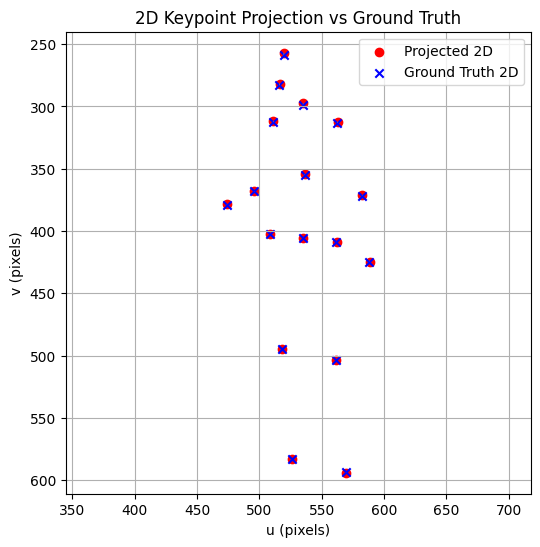

In [13]:
import matplotlib.pyplot as plt

# Ensure shapes are (17, 2)
assert proj_2d.shape == (17, 2), "Projected 2D shape mismatch"
assert gt_2d.shape == (17, 2), "Ground truth 2D shape mismatch"

plt.figure(figsize=(6, 6))

# Plot projected 2D points
plt.scatter(proj_2d[:, 0], proj_2d[:, 1], c='r', label='Projected 2D', marker='o')

# Plot ground truth 2D points
plt.scatter(gt_2d[:, 0], gt_2d[:, 1], c='b', label='Ground Truth 2D', marker='x')

# Optionally draw lines between corresponding joints
for i in range(17):
    plt.plot([proj_2d[i, 0], gt_2d[i, 0]], [proj_2d[i, 1], gt_2d[i, 1]], 'gray', linestyle='--', linewidth=0.5)

plt.title("2D Keypoint Projection vs Ground Truth")
plt.xlabel("u (pixels)")
plt.ylabel("v (pixels)")
plt.legend()
plt.gca().invert_yaxis()  # Image coordinates: origin is top-left
plt.grid(True)
plt.axis("equal")
plt.show()


## Another method:

#### Extrinsic Matrix:

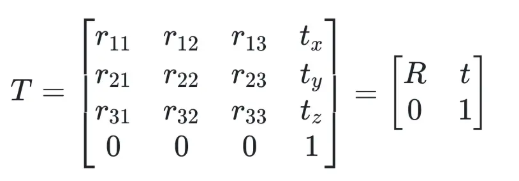

where R represents a 3x3 rotation matrix and t represents a 3x1 translation vector.

Assume a point Pw=(Xw, Yw, Zw) in the radar coordinate system (3D) is projected into a point Pc=(Xc, Yc, Zc) in the camera coordinate system (3D). The transformation process Pc=T x Pw can be expressed a




s: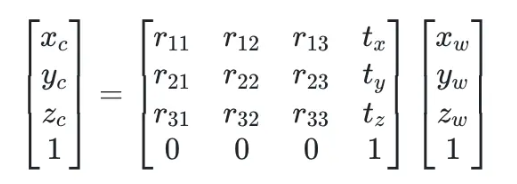


...
#### Intrinsic Matrix:

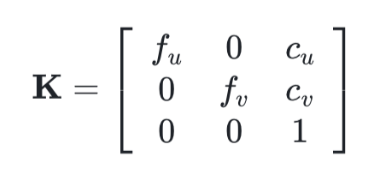

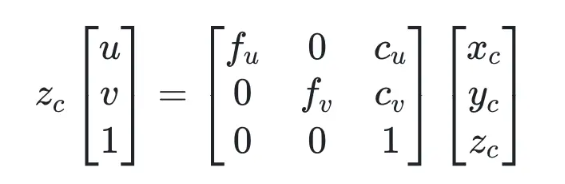g)

In [20]:
import numpy as np
import json

# === Step 1: Load World Coordinate 3D Joints ===
data_3d_world = ...  # (17, 3), from .npz
subject = 'S1'
cam_id = '55011271'  # Choose camera

# Correct loading of 3D world coordinates
data_3d_all = np.load('data_3d_h36m.npz', allow_pickle=True)['positions_3d'].item()
data_3d_world = data_3d_all[subject][action][frame_idx]  # (32, 3) or (17, 3)


# === Step 2: Load Intrinsics and Extrinsics from JSON ===
with open('camera-parameters.json') as f:
    camera_params = json.load(f)

# --- Intrinsic matrix (3x3) ---
K = np.array(camera_params['intrinsics'][cam_id]['calibration_matrix'])  # (3, 3)

# --- Extrinsic matrix: R and t ---
R = np.array(camera_params['extrinsics'][subject][cam_id]['R'])  # (3, 3)
t = np.array(camera_params['extrinsics'][subject][cam_id]['t']) / 1000.0  # (3,) in meters

# === Step 3: Build [R | t] → 3x4 extrinsic matrix ===
Rt = np.hstack((R, t.reshape(3, 1)))  # (3, 4)

# === Step 4: Convert Rt to 4x4 matrix by appending [0,0,0,1] ===
extrinsic_4x4 = np.eye(4) # append 0 0 0 1 as last row
extrinsic_4x4[:3, :] = Rt  # (4, 4)

h36m_to_17 = [0, 1, 2, 3, 6, 7, 8, 12, 13, 14, 15, 17, 18, 19, 25, 26, 27]
data_3d_world = data_3d[h36m_to_17]  # shape: (17, 3)

# === Step 5: Prepare homogeneous 3D points ===
X_world = data_3d_world.T  # (3, 17)
X_world_hom = np.vstack((X_world, np.ones((1, X_world.shape[1]))))  # (4, 17)

# === Step 6: Transform World → Camera Coordinates ===
X_cam_hom = extrinsic_4x4 @ X_world_hom  # (4, 17)
X_cam = X_cam_hom[:3]  # (3, 17)

# === Step 7: Project Camera 3D → 2D (pixels) ===
x = X_cam[0] / X_cam[2]
y = X_cam[1] / X_cam[2]

xy_normalized = np.vstack([x, y, np.ones_like(x)])  # (3, 17)
pixel_coords = K @ xy_normalized  # (3, 17)

proj_2d = pixel_coords[:2].T  # (17, 2)

# === Output ===
print("2D keypoints (pixel coordinates):")
print(proj_2d)


2D keypoints (pixel coordinates):
[[535.12197093 405.32179126]
 [508.78414795 402.03640486]
 [517.8730272  494.47499944]
 [526.11466589 583.01279594]
 [561.98584697 408.67279431]
 [561.43922515 503.71336937]
 [569.71915786 593.92671575]
 [536.42343699 354.30909129]
 [535.23882899 297.35842018]
 [516.33201215 281.60534756]
 [519.77509317 256.87446208]
 [562.81237297 312.19496368]
 [582.6648705  371.14832819]
 [588.46847402 424.46232883]
 [511.24910139 311.72989185]
 [495.93398574 367.8937873 ]
 [473.89684451 378.49192958]]
